In [41]:
import os
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt

# Install the correct versions
!pip install tensorflow scikeras

import tensorflow as tf
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Embedding, Dense, Dropout, GlobalMaxPool1D
from IPython.display import clear_output
from google.colab import files

# Use scikeras for compatibility with TensorFlow 2.x
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

In [42]:
class DatasetExtractor(BaseEstimator,TransformerMixin):
    """Extractor class that loads multiple Tweeter files in csv format."""

    COMBINDED_DATASET='/content/combined.csv'

    def transform(self,X,y=None):
        print("1")
        return self.hot_load()

    def hot_load(self):
        """Loads the pre-combined file if exists otherwise load all the files"""
        combined_file_path='/content/combined.csv'
        if os.path.isfile(combined_file_path):
            print('File Exists.Reloaded.')
            return pd.read_csv(combined_file_path, index_col=0)
        print('Loading Files..')
        combined_dataset=load_data()
        combined_dataset.to_csv(combined_file_path)
        return combined_dataset

    def load_data(self):
        """Loads multiple disaster related tweet file and returns a Single Pandas data frame"""
        combined_dataset=pd.DataFrame()
        for file_name in os.listdir(path=DATA_DIRECTORY):
            category=extract_category_name(file_name)
            df=pd.read_csv(f'{file_name}')
            df['category']= category
            combined_dataset=combined_dataset.append(df,ignore_index = True)
        return  combined_dataset

    def extract_category_name(self,file_name):
        """Helper method that extracts the Disaster Category from the file name"""
        category=file_name.split('.')[0]
        if '_' in category:
            category=category.split('_')[0]
        return category

In [43]:
class DatasetCleaner(BaseEstimator,TransformerMixin):
    """Removes Redundent features and rows with missing values"""
    def transform(self,X,y=None):
        print("2")
        columns=X.columns.tolist()
        X.columns=[column.strip() for column in columns]
        X=X.drop('tweet id',axis=1)
        X=X.dropna()
        X['tweet']=X['tweet'].str.replace('@', '')
        X['tweet']=X['tweet'].str.replace('#', '')
        X['tweet']=X['tweet'].str.replace('http\S+', '',regex=True)
        X['tweet']=X['tweet'].str.strip()
        X['tweet']=X['tweet'].str.lower()
        print("Columns after DatasetCleaner:", X.columns)
        return X

In [44]:
class DistributionValidSampler(BaseEstimator,TransformerMixin):
    """Samples the (related and random ) tweets with equal proportion"""
    def __init__(self,unrelated_size=None ,ignore_unrelated_proportion=True):
        self._unrelated_size=unrelated_size
        self._ignore_unrelated_proportion=ignore_unrelated_proportion


    def transform(self,X,y=None):
    # Debugging print
      print("3")
      print("Columns before processing:", X.columns)

      # Shuffle tweets
      X_ = X.sample(frac=1).reset_index(drop=True)

      X_ = self._label_categories(X_)
      related, unrelated = self._equal_split(X_)
      X_ = self._merge(related, unrelated)
      X_ = X_.drop('category', axis=1)
      return X_


    def _label_categories(self, X):
      """Assigns the category name to on-topic tweets and 'unrelated' to off-topic tweets."""

      print("Columns before labeling:", X.columns)  # 🔍 Debugging print

      if 'label' not in X.columns:
          raise ValueError("🚨 Error: 'label' column is missing before labeling. Check data source.")

      if self._ignore_unrelated_proportion:
          X['label'] = X.apply(
              lambda row: row['category'] if 'on-topic' in str(row['label']) else 'unrelated', axis=1
          )
      else:
          X['label'] = X.apply(
              lambda row: row['category'] if 'on-topic' in str(row['label']) else 'unrelated_' + row['category'], axis=1
          )

      print("Columns after labeling:", X.columns)
      if 'label' not in X.columns:
       raise ValueError("🚨 ERROR: 'label' column disappeared before labeling!")


      return X

    def _equal_split(self, X):
      """Splits the dataset into related and unrelated tweets."""
      print("Columns before splitting:", X.columns)

      # Check for missing 'label' column before filtering
      if 'label' not in X.columns:
          raise ValueError("❌ ERROR: 'label' column is missing before splitting!")

      related = X[X['label'].str.contains('unrelated') == False]
      unrelated = X[X['label'].str.contains('unrelated')]



      # Check if 'label' is still present
      if 'label' not in related.columns:
          raise ValueError("❌ ERROR: 'label' column is missing after filtering related!")
      if 'label' not in unrelated.columns:
          raise ValueError("❌ ERROR: 'label' column is missing after filtering unrelated!")

      ave_tweets = self._average_tweet_per_category(X)
      print("Columns after filtering (related):", related.columns)
      print("Columns after filtering (unrelated):", unrelated.columns)
      unrelated = self._slice(unrelated, size=self._unrelated_size, ave_size=ave_tweets)


      return related, unrelated



    def _merge(self,X1,X2):
        """Merges the dataframes toghether"""

        X = pd.concat([X1, X2], ignore_index=True)

        print("merging",X.columns)
        return X

    def _slice(self,X, size ,ave_size):
        """Extracts a subset of rows from a dataframe"""
        if size is None:
            size =ave_size
        if size < X.shape[0]:
            return X[:size]
        return X

    def _average_tweet_per_category(self,X):
        """Calculate the average number of tweets across all tweet categories"""
        print("average_tweet",X.columns)
        category_values=pd.DataFrame(X['label'].value_counts())
        print(category_values.columns)
        category_values=category_values.drop('unrelated',axis=0)
        return int(category_values['count'].mean())

In [45]:
class TextTokenizer(BaseEstimator,TransformerMixin):

    def __init__(self,pad_sequences,num_words=10000,max_length=100,max_pad_length=100 ):
        self._num_words=num_words
        self.max_length=max_length
        self._tokenizer=None
        self._pad_sequences=pad_sequences
        self._max_pad_length=max_pad_length
        self.vocab_size=None
        self.tokenizer=None

    def transform(self,X,y=None):

        print("4")
        self.tokenizer,self.vocab_size=self._get_tokenizer(X['tweet'])
        X['tweet_encoded']=self.tokenizer.texts_to_sequences(X['tweet'])
        X['tweet_encoded']= X['tweet_encoded'].apply(lambda x: self._pad_sequences([x],maxlen=self._max_pad_length ,padding='post')[0])

        return X
    def _get_tokenizer(self,X):
        tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=self._num_words)
        tokenizer.fit_on_texts(X)
        vocab_size=len(tokenizer.word_index)+1
        return tokenizer,vocab_size

In [46]:
class LabelOneHotEncoder(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.label_encoder=None
        self.one_hot_encoder=None

    def transform(self,X,y=None):
        print("5")
        self.label_encoder=LabelEncoder().fit(X['label'])
        self.one_hot_encoder=to_categorical
        num_classes=len(set(X['label']))
        X['label_encoded']= self.label_encoder.transform(X['label'].values)
        X['label_one_hot']= X['label_encoded'].apply(lambda x: self.one_hot_encoder([x],num_classes=num_classes)[0])

        return X

In [48]:
class PassThroughTransformer(BaseEstimator,TransformerMixin):
    """Pass Through Trasformer to by pass the sklean pipleline limitation """
    def transform(self,X,y=None):
        print("6")
        return X
    def fit(self,X,y=None):
        return X

In [49]:
pad_sequence=tf.keras.preprocessing.sequence.pad_sequences


pipeline =Pipeline(steps=[
    ('extractor',DatasetExtractor()),
    ('cleaner',DatasetCleaner()),
    ('distribution-validator',DistributionValidSampler(unrelated_size=None ,ignore_unrelated_proportion=True)),
    ('tokenizer',TextTokenizer(pad_sequence)),
    ('one-hot-encoder',LabelOneHotEncoder()),
    ('pass-through',PassThroughTransformer()),

])
cleaned=pipeline.transform(None)
cleaned.head()

1
File Exists.Reloaded.
2
Columns after DatasetCleaner: Index(['tweet', 'label', 'category'], dtype='object')
3
Columns before processing: Index(['tweet', 'label', 'category'], dtype='object')
Columns before labeling: Index(['tweet', 'label', 'category'], dtype='object')
Columns after labeling: Index(['tweet', 'label', 'category'], dtype='object')
Columns before splitting: Index(['tweet', 'label', 'category'], dtype='object')
average_tweet Index(['tweet', 'label', 'category'], dtype='object')
Index(['count'], dtype='object')
Columns after filtering (related): Index(['tweet', 'label', 'category'], dtype='object')
Columns after filtering (unrelated): Index(['tweet', 'label', 'category'], dtype='object')
merging Index(['tweet', 'label', 'category'], dtype='object')
4
5
6


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,tweet,label,tweet_encoded,label_encoded,label_one_hot
0,rt newscientist: climate change blamed as aust...,floods,"[2, 951, 501, 465, 780, 32, 43, 710, 22, 186, ...",3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
1,rt yvonnen_kvue: rt davidschechter seeing leve...,explosion,"[2, 9190, 2412, 2, 7767, 818, 1669, 261, 3, 91...",2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
2,video: chopper pulls toddler from flood: drama...,floods,"[83, 2413, 2535, 1884, 22, 9, 1082, 83, 35, 5,...",3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
3,i refuse to find a hurricane called sandy scar...,hurricane,"[11, 4668, 4, 367, 6, 12, 855, 23, 447, 76, 0,...",4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
4,thinking of all albertans affected by the floo...,floods,"[530, 5, 28, 2346, 65, 29, 1, 105, 6038, 355, ...",3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"


In [50]:
X_train,X_test,y_train,y_test =train_test_split(cleaned['tweet_encoded'],cleaned['label_one_hot'],test_size=0.3,stratify=cleaned['label_encoded'])
X_train=np.array(X_train.values.tolist())
X_test=np.array(X_test.values.tolist())
y_train=np.array(y_train.values.tolist())
y_test=np.array(y_test.values.tolist())

In [51]:
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []

        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1

        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
plot_losses = PlotLosses()

def save_model(model,save_name):
    with open(save_name,'w+') as f:
        f.write(model.to_json())
    model.save_weights(save_name+'.h5')

In [53]:
tokenizer=pipeline.named_steps['tokenizer']
max_length=tokenizer.max_length
vocab_size=tokenizer.vocab_size
embeding_dim=50
num_classes=y_train[0].shape[0]
model=Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embeding_dim,input_length=max_length))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.2))
model.add(Dense(10,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'] )
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_4               │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

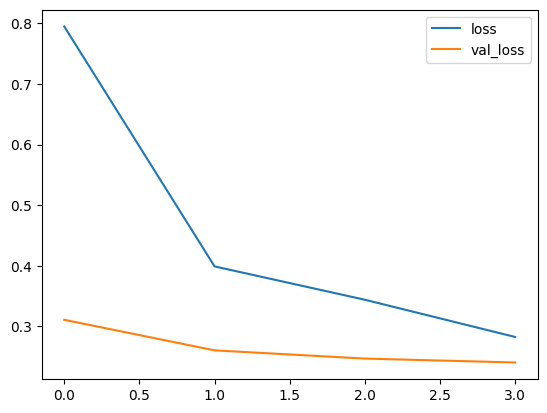

In [54]:
model.fit(X_train,y_train,epochs=4,batch_size=10,verbose=0,validation_split=0.2,callbacks=[plot_losses])
save_model(model,'model.weights')

In [55]:
json_file = open('model.weights', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.weights.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
compile_metrics: 93.20%


In [58]:
vocab_size=pipeline.named_steps['tokenizer'].vocab_size
max_length=pipeline.named_steps['tokenizer'].max_length
label_encoder=pipeline.named_steps['one-hot-encoder'].label_encoder
tokenizer=pipeline.named_steps['tokenizer'].tokenizer
max_length=pipeline.named_steps['tokenizer'].max_length


x=['large explosion at a texas fertilizer plant...multiple injuries reported...local hospital told to expect up to 100 patients: via ap']
x_seq=tokenizer.texts_to_sequences(x)[0]
x_pad=tf.keras.preprocessing.sequence.pad_sequences([x_seq],maxlen=max_length ,padding='post')[0]
x_pad=np.array(x_pad)
x_pad=x_pad.reshape(1,100)
x_pad.shape
predict=np.argmax(loaded_model.predict(x_pad), axis=-1)
score=max(loaded_model.predict(x_pad)[0])
print(predict)
print(label_encoder.inverse_transform(predict))
print('score',score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[2]
['explosion']
score 0.9997805
